On commence par importer les librairies nécessaires.

In [1]:
import numpy as np
import random
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.distributions import Categorical
from copy import deepcopy
from matplotlib import pyplot as plt

On crée notre environnement d'entraînement CartPole-v1 avec Gym.

In [2]:
env = gym.make("CartPole-v1")

L'interface de Gym est assez élégante. Voici un exemple utilisant seulement une politique aléatoire, donc très sous-optimale.

In [3]:
s = env.reset() # Appel à mu_0
done = False
rewards = 0

while not done: # On va boucler tant que la trajectoire n'est pas finie
    env.render() # Appel pour ajouter une image au vidéo
    a = env.action_space.sample() # Pour l'instant on prend une action aléatoire
    
    # On appelle step(a) pour faire progresser l'environnement.
    # Ça retourne le prochain état, le reward et si la trajectoire est terminée.
    next_s, r, done, _ = env.step(a)
    
    s = next_s
    rewards += r
    
print(f"Finished after a total reward of {rewards}")
env.close()

Finished after a total reward of 18.0


On ajoute une fonction intermédiaire pour la reproductibilité de nos expériences. On fixe les germes aléatoires de l'environnement est des librairies numpy et torch.

In [4]:
def set_random_seed(environment, seed=42):
    environment.seed(seed)
    environment.action_space.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

C'est bien beau une politique aléatoire, mais ce qu'on veut, c'est apprendre à faire tenir le poteau sur le chariot ! 

On utilise donc un réseau de neurones qui pourra prendre en entrée un état et retournera un vecteur de la taille de l'espace d'actions. 

Pourquoi retourner une valeur pour chaque action ? 
 - Quand on veut apprendre une politique, on voudra prédire une _distribution_ sur les actions possibles.
 - Quand on veut apprendre une Q function, on voudra prédire la _valeur espérée_ de chaque (s, a) pour un état en entrée. 

In [5]:
class NeuralNet(nn.Module):
    def __init__(self, environment, hidden_size=128):
        super().__init__()
        # On utilise directement observation_space et action_space pour 
        # bâtir notre réseau de neurones.
        self.first_layer = nn.Linear(environment.observation_space.shape[0], hidden_size)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.6)
        self.output = nn.Linear(hidden_size, environment.action_space.n)
    
    def forward(self, x):
        x = self.first_layer(x)
        x = self.dropout(x)
        x = self.activation(x)
        return self.output(x)
    
net = NeuralNet(env)
print(net)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# Example d'appel
s = env.reset()
s = torch.from_numpy(s).float().to(device)
net(s)

NeuralNet(
  (first_layer): Linear(in_features=4, out_features=128, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.6, inplace=False)
  (output): Linear(in_features=128, out_features=2, bias=True)
)


tensor([0.7690, 0.4107], device='cuda:0', grad_fn=<AddBackward0>)

Comme notre réseau de neurones n'est pas entraîné, il produit encore des actions aléatoires, mais on peut tout de même l'utiliser avec notre environnement.

In [6]:
# On met ça dans une fonction pour plus tard !
def run_with_net(net):
    set_random_seed(env)
    s = env.reset() # Appel à mu_0
    s = torch.from_numpy(s).float().to(device) # NOUVEAU : utilisation de PyTorch
    done = False
    rewards = 0

    while not done: # On va boucler tant que la trajectoire n'est pas finie
        env.render() # Appel pour ajouter une image au vidéo

        # NOUVEAU: Production de l'action par le réseau
        out = net(s) # On produit le vecteur brut
        a = out.argmax().item() # On sélectionne l'action avec la plus grande probabilité

        # On appelle step(a) pour faire progresser l'environnement.
        # Ça retourne le prochain état, le reward et si la trajectoire est terminée.
        next_s, r, done, _ = env.step(a)

        # NOUVEAU : utilisation de PyTorch
        s = torch.from_numpy(next_s).float().to(device)
        rewards += r

    print(f"Finished after a total reward of {rewards}")
    env.close()
    
run_with_net(net)

Finished after a total reward of 16.0


On a maintenant tout ce qu'il nous faut pour tester nos algorithmes, pas besoin de rien de plus !

# Premier algorithme: REINFORCE

REINFORCE est un algorithme de gradient de politique, qui fonctionne comme suit:

1. On génère une trajectoire complète, sans aucune mise à jour de gradient.
2. Quand la trajectoire est terminée, on calcule la somme pondérée des récompenses G_t à partir de chaque état.
3. Pour chaque état de la trajectoire, on récolte aussi log_proba_t, la log_proba de l'action prise.
4. On utilise la moyenne des -G_t * log_proba_t comme perte. Le - est parce qu'on fait une _ascension_.
5. On répète jusqu'à convergence.

Par défaut, on va vouloir gérer le compromis exploration-exploitation en _pigeant_ de notre distribution ici.

In [7]:
# On commence par se définir une fonction utilitaire pour calculer les G_t
def extract_cumulated_rewards(rewards, gamma):
    '''
    Takes as input a list of rewards and a gamma discount factor and returns the list of cumulated discounted rewards.

    The first item in the returned list is G_0 = r_0 + gamma * r_1 + gamma^2 * r_2 + ... + gamma^T * r_T.
    '''
    returns = []
    G = 0

    # On parcoure de t=T à 0
    for r in reversed(rewards):
        G = gamma * G + r
        returns.append(G)

    # On réinverse pour avoir G_0, G_1, ..., G_T
    return list(reversed(returns))


def reinforce(gamma=0.9, learning_rate=5e-3, n_trajectories=200):
    set_random_seed(env)
    net = NeuralNet(env)
    net = net.to(device)
    optim = Adam(net.parameters(), lr=learning_rate)

    all_G_0 = []
    for i in range(n_trajectories):
        # On va devoir accumuler les états, les actions, les rewards et les log_proba
        # pour tous les steps t de la trajectoire.
        visited_states = []
        actions_taken = []
        rewards = []
        log_probas = []
        # On collecte la durée des episodes juste pour le output.
        G_0 = 0.0
        
        s = env.reset()
        s = torch.from_numpy(s).float().to(device)
        done = False
        
        while not done:
            logits = net(s) # On produit le vecteur brut
            action_probas = F.softmax(logits, dim=-1) # On transforme en distribution de probabilité
            m = Categorical(action_probas)
            a = m.sample() # On pige selon la distribution
            next_s, r, done, _ = env.step(a.item())
            G_0 += r

            # Storage
            visited_states.append(s)
            actions_taken.append(a)
            rewards.append(r)
            log_probas.append(m.log_prob(a))

            s = torch.from_numpy(next_s).float().to(device)

        # On calcule et entrepose les G_t
        g_t = extract_cumulated_rewards(rewards, gamma)
        all_G_0.append(G_0)

        # Calcul de la perte
        g_t = torch.FloatTensor(g_t).to(device)
        log_probas = torch.stack(log_probas)
        
        optim.zero_grad()
        loss = (g_t * -log_probas).sum()
        loss.backward()
        optim.step()
        
        if (i + 1) % 10 == 0 :
            print(f"After {i + 1} trajectories, we have G_0 = {G_0:.2f}")
    
    env.close()
    
    return net, all_G_0

reinforce_net, reinforce_returns = reinforce()

After 10 trajectories, we have G_0 = 8.00
After 20 trajectories, we have G_0 = 10.00
After 30 trajectories, we have G_0 = 44.00
After 40 trajectories, we have G_0 = 47.00
After 50 trajectories, we have G_0 = 53.00
After 60 trajectories, we have G_0 = 28.00
After 70 trajectories, we have G_0 = 73.00
After 80 trajectories, we have G_0 = 82.00
After 90 trajectories, we have G_0 = 46.00
After 100 trajectories, we have G_0 = 38.00
After 110 trajectories, we have G_0 = 116.00
After 120 trajectories, we have G_0 = 66.00
After 130 trajectories, we have G_0 = 30.00
After 140 trajectories, we have G_0 = 29.00
After 150 trajectories, we have G_0 = 57.00
After 160 trajectories, we have G_0 = 135.00
After 170 trajectories, we have G_0 = 103.00
After 180 trajectories, we have G_0 = 97.00
After 190 trajectories, we have G_0 = 97.00
After 200 trajectories, we have G_0 = 246.00


In [8]:
run_with_net(reinforce_net)

Finished after a total reward of 500.0


REINFORCE souffre très clairement d'un problème de stabilité dans l'apprentissage si l'on se fie à notre exemple. Une manière généralement utilisée pour stabiliser l'algorithme est d'appliquer une _transformation blanchissante_ sur les G_t avant de calculer la perte.

La transformation blanchissante consiste à soustraite la moyenne des G_t et à diviser par la déviation standard. Cet ajustement ramène les G_t à une moyenne de 0 et une déviation standard de 1 et ce, pour toutes les trajectoires.

In [9]:
def reinforce_normalized(gamma=0.9, learning_rate=5e-3, n_trajectories=200):
    set_random_seed(env)
    net = NeuralNet(env)
    net = net.to(device)
    optim = Adam(net.parameters(), lr=learning_rate)

    all_G_0 = []
    for i in range(n_trajectories):
        # On va devoir accumuler les états, les actions, les rewards et les log_proba
        # pour tous les steps t de la trajectoire.
        visited_states = []
        actions_taken = []
        rewards = []
        log_probas = []
        # On collecte la durée des épisodes, juste pour le output.
        G_0 = 0.0
        
        s = env.reset()
        s = torch.from_numpy(s).float().to(device)
        done = False
        
        while not done:
            logits = net(s) # On produit le vecteur brut
            action_probas = F.softmax(logits, dim=-1) # On transforme en distribution de probabilité
            m = Categorical(action_probas)
            a = m.sample() # On pige selon la distribution
            next_s, r, done, _ = env.step(a.item())
            G_0 += r

            # Storage
            visited_states.append(s)
            actions_taken.append(a)
            rewards.append(r)
            log_probas.append(m.log_prob(a))

            s = torch.from_numpy(next_s).float().to(device)

        # On calcule et entrepose les G_t
        g_t = extract_cumulated_rewards(rewards, gamma)
        all_G_0.append(G_0)

        # Calcul de la perte
        g_t = torch.FloatTensor(g_t).to(device)
        # NOUVEAUTÉ : On soustraie la moyenne et divise par le déviation standard
        g_t = (g_t - g_t.mean()) / (g_t.std() + np.finfo(np.float32).eps.item())
        log_probas = torch.stack(log_probas)
        
        optim.zero_grad()
        loss = (g_t * -log_probas).sum()
        loss.backward()
        optim.step()
        
        if (i + 1) % 10 == 0 :
            print(f"After {i + 1} trajectories, we have G_0 = {G_0:.2f}")
    
    env.close()
    
    return net, all_G_0

reinforce_normalized_net, reinforce_normalized_returns = reinforce_normalized()

After 10 trajectories, we have G_0 = 9.00
After 20 trajectories, we have G_0 = 10.00
After 30 trajectories, we have G_0 = 43.00
After 40 trajectories, we have G_0 = 34.00
After 50 trajectories, we have G_0 = 24.00
After 60 trajectories, we have G_0 = 18.00
After 70 trajectories, we have G_0 = 98.00
After 80 trajectories, we have G_0 = 50.00
After 90 trajectories, we have G_0 = 50.00
After 100 trajectories, we have G_0 = 75.00
After 110 trajectories, we have G_0 = 34.00
After 120 trajectories, we have G_0 = 69.00
After 130 trajectories, we have G_0 = 366.00
After 140 trajectories, we have G_0 = 212.00
After 150 trajectories, we have G_0 = 288.00
After 160 trajectories, we have G_0 = 161.00
After 170 trajectories, we have G_0 = 244.00
After 180 trajectories, we have G_0 = 152.00
After 190 trajectories, we have G_0 = 266.00
After 200 trajectories, we have G_0 = 500.00


On visualise notre agent entraîné par REINFORCE pur :

In [10]:
run_with_net(reinforce_normalized_net)

Finished after a total reward of 500.0


# Second algorithme: Deep Q-Network  (DQN)

DQN est un algorithme par fonction de valeur, qui fonctionne comme suit:

1. On entretient un _buffer_ de transitions (s, a, r, s'), d'une taille fixe, généralement assez grosse.
2. Entre chaque pas de temps, on va faire une mise à jour des poids en pigeant une minibatch de notre buffer.
3. La mise à jour sera faite selon l'équation de Bellman vue dans les diapos.

Cette fois-ci, on va plutôt gérer le compromis exploration-exploitation avec une politique epsilon-greedy. Pour éventuellement permettre un apprentissage significatif, on va graduellement faire descendre le facteur epsilon utilisé en fonction du nombre de trajectoires effectuées.

In [11]:
class ReplayBuffer:
    """
    Replay buffer object that stores elements up until a certain maximum size.
    """
    def __init__(self, buffer_size):
        """
        Init the buffer and store buffer_size property.
        """
        self.__buffer_size = buffer_size
        self.data = []

    def store(self, element):
        """
        Stores an element.

        If the buffer is already full, pop the oldest element inside.
        """
        # On ajoute toujours à droite de la liste
        self.data.append(element)

        # Si la liste est trop pleine, on supprime à gauche
        if len(self.data) > self.__buffer_size:
            del self.data[0]

    def get_batch(self, batch_size):
        """
        Randomly samples batch_size elements from the buffer.

        Returns the list of sampled elements.
        """
        return random.sample(self.data, batch_size)

def dqn(gamma=0.9, learning_rate=1e-3, n_trajectories=300, 
        batch_size=128, buffer_size=50000, epsilon_decay=0.98, 
        epsilon_min=0.01):
    set_random_seed(env)
    net = NeuralNet(env)
    net = net.to(device)
    optim = Adam(net.parameters(), lr=learning_rate)
    
    # NOUVEAU: On crée le replay buffer et on initialise epsilon
    replay_buffer = ReplayBuffer(buffer_size)
    epsilon = 1.0
    
    all_G_0 = []
    
    for i in range(n_trajectories):
        # NOUVEAU : On n'a plus besoin d'entreposer les infos d'une trajectoire
        G = 0.0
        
        s = env.reset()
        s = torch.from_numpy(s).float().to(device)
        done = False
        
        while not done:
            q_vals = net(s) # On produit les q valeurs
            # NOUVEAU : Epsilon greedy
            if np.random.rand() < epsilon:
                a = env.action_space.sample() # Action aléatoire
            else:
                with torch.no_grad():
                    a = q_vals.argmax().item()
                
            next_s, r, done, _ = env.step(a)
            G += r # NOUVEAU
            next_s = torch.from_numpy(next_s).float().to(device)

            # Storage
            replay_buffer.store((s, a, r, next_s, done))

            s = next_s
            
            # NOUVEAU : Mise à jour DQN
            if len(replay_buffer.data) > batch_size:
                # On va chercher une batch dans le buffer
                minibatch = replay_buffer.get_batch(batch_size)

                # On passe tout ça en tenseur PyTorch
                states = torch.vstack([x[0] for x in minibatch]).to(device)
                actions_taken = torch.LongTensor([x[1] for x in minibatch]).to(device)
                rewards = torch.FloatTensor([x[2] for x in minibatch]).to(device)
                next_states = torch.vstack([x[3] for x in minibatch]).to(device)
                terminal = torch.ByteTensor([x[4] for x in minibatch]).to(device)

                # Les prédictions Q(s, a) sont obtenues via gather
                q_vals_predicted = net(states)
                q_preds = q_vals_predicted.gather(1, actions_taken.unsqueeze(-1)).squeeze()
                
                # Les cibles r + gamma * Q(s', a')
                # IMPORTANT : On utilise detach() pour la prochaine action.
                # On ne veut pas backpropper sur celle-ci parce qu'elle est 
                # potentiellement hors de notre jeu de données et pourrait nuire 
                # à la stabilité.
                next_q_vals_predicted = net(next_states)
                next_action_vals_predicted = next_q_vals_predicted.max(dim=-1)[0].detach()
                targets = rewards + gamma * next_action_vals_predicted * (1 - terminal)
                
                optim.zero_grad()
                # Perte Quadratique entre les deux côtés de l'équation de Bellman
                loss = ((q_preds - targets) ** 2).sum()
                loss.backward()
                optim.step()
        

        # On entrepose les G_0
        all_G_0.append(G)
        
        # Mise à jour de epsilon
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        
        if (i + 1) % 10 == 0 :
            print(f"After {i + 1} trajectories, we have G_0 = {G:.2f}. {epsilon:.3f}")
    
    env.close()
    
    return net, all_G_0

dqn_net, dqn_returns = dqn()

After 10 trajectories, we have G_0 = 20.00. 0.817
After 20 trajectories, we have G_0 = 13.00. 0.668
After 30 trajectories, we have G_0 = 12.00. 0.545
After 40 trajectories, we have G_0 = 23.00. 0.446
After 50 trajectories, we have G_0 = 17.00. 0.364
After 60 trajectories, we have G_0 = 55.00. 0.298
After 70 trajectories, we have G_0 = 51.00. 0.243
After 80 trajectories, we have G_0 = 20.00. 0.199
After 90 trajectories, we have G_0 = 92.00. 0.162
After 100 trajectories, we have G_0 = 45.00. 0.133
After 110 trajectories, we have G_0 = 57.00. 0.108
After 120 trajectories, we have G_0 = 38.00. 0.089
After 130 trajectories, we have G_0 = 36.00. 0.072
After 140 trajectories, we have G_0 = 36.00. 0.059
After 150 trajectories, we have G_0 = 114.00. 0.048
After 160 trajectories, we have G_0 = 97.00. 0.039
After 170 trajectories, we have G_0 = 41.00. 0.032
After 180 trajectories, we have G_0 = 108.00. 0.026
After 190 trajectories, we have G_0 = 13.00. 0.022
After 200 trajectories, we have G_0 = 

In [12]:
run_with_net(dqn_net)

Finished after a total reward of 120.0


Regardons de manière un peu plus rigoureuse comment nos algorithmes se comparent:

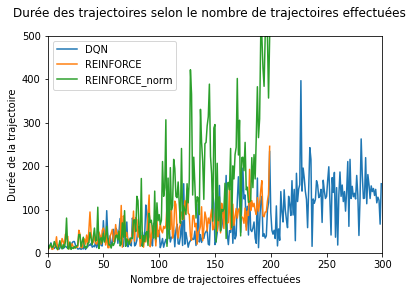

In [13]:
plt.plot(dqn_returns, label="DQN")
plt.plot(reinforce_returns, label="REINFORCE")
plt.plot(reinforce_normalized_returns, label="REINFORCE_norm")
plt.legend()

plt.xlim(0, 300)
plt.ylim(0, 500)

plt.suptitle("Durée des trajectoires selon le nombre de trajectoires effectuées")
plt.xlabel("Nombre de trajectoires effectuées")
plt.ylabel("Durée de la trajectoire")

plt.show()

Donc, malgré un nombre de mises à jour des poids bien plus élevés que REINFORCE, DQN est aussi instable que REINFORCE sans normalisation et n'apprend pas plus vite.

Intuitivement, c'est bien connu dans la littérature que CartPole est plus facile pour les algorithmes par gradient de politique que pour les algorithmes par fonction de valeur. Pourquoi à votre avis ? 